In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../../../../Datasets/MNIST_data/", one_hot=True)

num_sample = mnist.train.num_examples
print("num_sample: ", num_sample)
input_dim = mnist.train.images[0].shape[0]
print("input_dim: ", input_dim)
w = h = 28

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../../../Datasets/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../../../Datasets/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../../../../Datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../../../Datasets/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
num_sample:  55000
input_dim:  784


In [3]:
class VariantionalAutoencoder(object):

    def __init__(self, learning_rate=1e-3, batch_size=100, n_z=10):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(name='x', dtype=tf.float32, shape=[None, input_dim])
        print("self.x: ", self.x)

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 512, scope='enc_fc1', activation_fn=tf.nn.elu)
        print("f1: ", f1)
        f2 = fc(f1, 384, scope='enc_fc2', activation_fn=tf.nn.elu)
        print("f2: ", f2)
        f3 = fc(f2, 256, scope='enc_fc3', activation_fn=tf.nn.elu)
        print("f3: ", f3)
        self.z_mu = fc(f3, self.n_z, scope='enc_fc4_mu', activation_fn=None)
        print("self.z_mu: ", self.z_mu)
        self.z_log_sigma_sq = fc(f3, self.n_z, scope='enc_fc4_sigma', activation_fn=None)
        print("self.z_log_sigma_sq: ", self.z_log_sigma_sq)
        eps = tf.random_normal(shape=tf.shape(self.z_log_sigma_sq), mean=0, stddev=1, dtype=tf.float32)
        print("eps: ", eps)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps # The reparameterization trick
        print("self.z: ", self.z)

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 256, scope='dec_fc1', activation_fn=tf.nn.elu)
        print("g1: ", g1)
        g2 = fc(g1, 384, scope='dec_fc2', activation_fn=tf.nn.elu)
        print("g2: ", g2)
        g3 = fc(g2, 512, scope='dec_fc3', activation_fn=tf.nn.elu)
        print("g3: ", g3)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', activation_fn=tf.sigmoid)
        print("self.x_hat: ", self.x_hat)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        print("recon_loss: ", recon_loss)
        self.recon_loss = tf.reduce_mean(recon_loss)
        print("self.recon_loss: ", self.recon_loss)

        # Latent loss
        # Kullback Leibler divergence: measure the difference between two distributions
        # Here we measure the divergence between the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - tf.exp(self.z_log_sigma_sq), axis=1)
        print("latent_loss: ", latent_loss)
        self.latent_loss = tf.reduce_mean(latent_loss)
        print("self.latent_loss: ", self.latent_loss)

        self.total_loss = tf.reduce_mean(recon_loss + latent_loss)
        print("self.total_loss: ", self.total_loss)
        self.train_op = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.total_loss)
        print("self.train_op: ", self.train_op)
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, loss, recon_loss, latent_loss = self.sess.run(
            [self.train_op, self.total_loss, self.recon_loss, self.latent_loss],
            feed_dict={self.x: x}
        )
        return loss, recon_loss, latent_loss

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z

In [4]:
def trainer(learning_rate=1e-3, batch_size=100, num_epoch=75, n_z=10):
    model = VariantionalAutoencoder(learning_rate=learning_rate, batch_size=batch_size, n_z=n_z)

    for epoch in range(num_epoch):
        for iter in range(num_sample // batch_size):
            # Obtina a batch
            batch = mnist.train.next_batch(batch_size)
            # Execute the forward and the backward pass and report computed losses
            loss, recon_loss, latent_loss = model.run_single_step(batch[0])
        
        if epoch % 5 == 0:
            print('[Epoch {}] Loss: {}, Recon loss: {}, Latent loss: {}'.format(epoch, loss, recon_loss, latent_loss))
            
    print('Done!')
    return model

In [5]:
# Train the model
model = trainer(learning_rate=1e-4,  batch_size=100, num_epoch=100, n_z=5)

self.x:  Tensor("x:0", shape=(?, 784), dtype=float32)
f1:  Tensor("enc_fc1/Elu:0", shape=(?, 512), dtype=float32)
f2:  Tensor("enc_fc2/Elu:0", shape=(?, 384), dtype=float32)
f3:  Tensor("enc_fc3/Elu:0", shape=(?, 256), dtype=float32)
self.z_mu:  Tensor("enc_fc4_mu/BiasAdd:0", shape=(?, 5), dtype=float32)
self.z_log_sigma_sq:  Tensor("enc_fc4_sigma/BiasAdd:0", shape=(?, 5), dtype=float32)
eps:  Tensor("random_normal:0", shape=(?, 5), dtype=float32)
self.z:  Tensor("add:0", shape=(?, 5), dtype=float32)
g1:  Tensor("dec_fc1/Elu:0", shape=(?, 256), dtype=float32)
g2:  Tensor("dec_fc2/Elu:0", shape=(?, 384), dtype=float32)
g3:  Tensor("dec_fc3/Elu:0", shape=(?, 512), dtype=float32)
self.x_hat:  Tensor("dec_fc4/Sigmoid:0", shape=(?, 784), dtype=float32)
recon_loss:  Tensor("Neg:0", shape=(?,), dtype=float32)
self.recon_loss:  Tensor("Mean:0", shape=(), dtype=float32)
latent_loss:  Tensor("mul_3:0", shape=(?,), dtype=float32)
self.latent_loss:  Tensor("Mean_1:0", shape=(), dtype=float32)
self

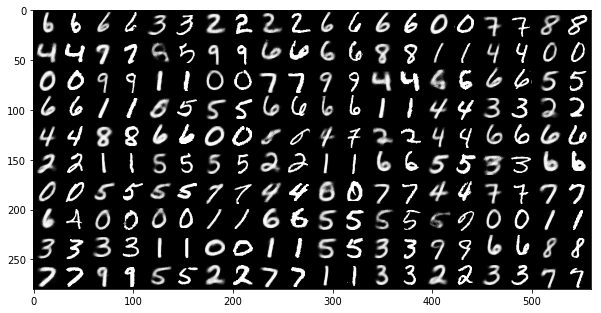

In [6]:
# Test the trained model: reconstruction
batch = mnist.test.next_batch(100)
x_reconstructed = model.reconstructor(batch[0])

n = np.sqrt(model.batch_size).astype(np.int32)
I_reconstructed = np.empty((h*n, 2*w*n))
for i in range(n):
    for j in range(n):
        x = np.concatenate(
            (x_reconstructed[i*n+j, :].reshape(h, w), 
             batch[0][i*n+j, :].reshape(h, w)),
            axis=1
        )
        I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = x

plt.figure(figsize=(10, 20))
plt.imshow(I_reconstructed, cmap='gray')

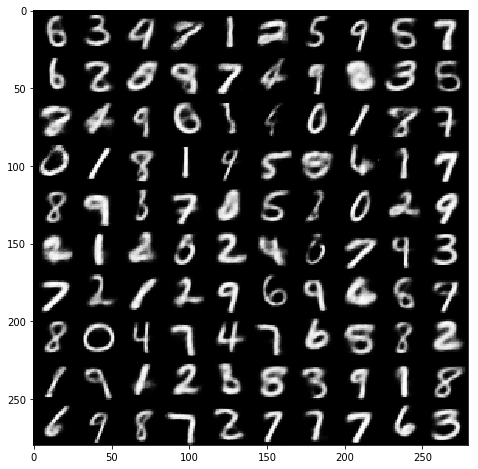

In [7]:
# Test the trained model: generation
# Sample noise vectors from N(0, 1)
z = np.random.normal(size=[model.batch_size, model.n_z])
x_generated = model.generator(z)

n = np.sqrt(model.batch_size).astype(np.int32)
I_generated = np.empty((h*n, w*n))
for i in range(n):
    for j in range(n):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i*n+j, :].reshape(28, 28)

plt.figure(figsize=(8, 8))
plt.imshow(I_generated, cmap='gray')

In [8]:
tf.reset_default_graph()
# Train the model with 2d latent space
model_2d = trainer(learning_rate=1e-4,  batch_size=100, num_epoch=50, n_z=2)

self.x:  Tensor("x:0", shape=(?, 784), dtype=float32)
f1:  Tensor("enc_fc1/Elu:0", shape=(?, 512), dtype=float32)
f2:  Tensor("enc_fc2/Elu:0", shape=(?, 384), dtype=float32)
f3:  Tensor("enc_fc3/Elu:0", shape=(?, 256), dtype=float32)
self.z_mu:  Tensor("enc_fc4_mu/BiasAdd:0", shape=(?, 2), dtype=float32)
self.z_log_sigma_sq:  Tensor("enc_fc4_sigma/BiasAdd:0", shape=(?, 2), dtype=float32)
eps:  Tensor("random_normal:0", shape=(?, 2), dtype=float32)
self.z:  Tensor("add:0", shape=(?, 2), dtype=float32)
g1:  Tensor("dec_fc1/Elu:0", shape=(?, 256), dtype=float32)
g2:  Tensor("dec_fc2/Elu:0", shape=(?, 384), dtype=float32)
g3:  Tensor("dec_fc3/Elu:0", shape=(?, 512), dtype=float32)
self.x_hat:  Tensor("dec_fc4/Sigmoid:0", shape=(?, 784), dtype=float32)
recon_loss:  Tensor("Neg:0", shape=(?,), dtype=float32)
self.recon_loss:  Tensor("Mean:0", shape=(), dtype=float32)
latent_loss:  Tensor("mul_3:0", shape=(?,), dtype=float32)
self.latent_loss:  Tensor("Mean_1:0", shape=(), dtype=float32)
self

c:\anaconda2\envs\py3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[Epoch 0] Loss: 177.72560119628906, Recon loss: 172.74574279785156, Latent loss: 4.979864597320557
[Epoch 5] Loss: 155.4378662109375, Recon loss: 150.05982971191406, Latent loss: 5.378042221069336
[Epoch 10] Loss: 158.05763244628906, Recon loss: 152.70887756347656, Latent loss: 5.348763942718506
[Epoch 15] Loss: 155.32742309570312, Recon loss: 149.8221435546875, Latent loss: 5.50527811050415
[Epoch 20] Loss: 152.17286682128906, Recon loss: 146.25399780273438, Latent loss: 5.918877124786377
[Epoch 25] Loss: 146.685302734375, Recon loss: 140.7919464111328, Latent loss: 5.893338203430176
[Epoch 30] Loss: 142.9436492919922, Recon loss: 136.86106872558594, Latent loss: 6.082571506500244
[Epoch 35] Loss: 145.24102783203125, Recon loss: 139.19224548339844, Latent loss: 6.048789024353027
[Epoch 40] Loss: 141.38763427734375, Recon loss: 135.10398864746094, Latent loss: 6.283639907836914
[Epoch 45] Loss: 149.1840362548828, Recon loss: 142.9855499267578, Latent loss: 6.1984944343566895
Done!


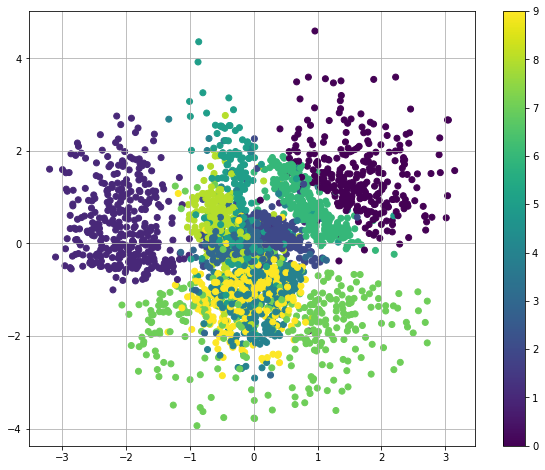

In [9]:
# Test the trained model: transformation
batch = mnist.test.next_batch(3000)
z = model_2d.transformer(batch[0])
plt.figure(figsize=(10, 8)) 
plt.scatter(z[:, 0], z[:, 1], c=np.argmax(batch[1], 1))
plt.colorbar()
plt.grid()

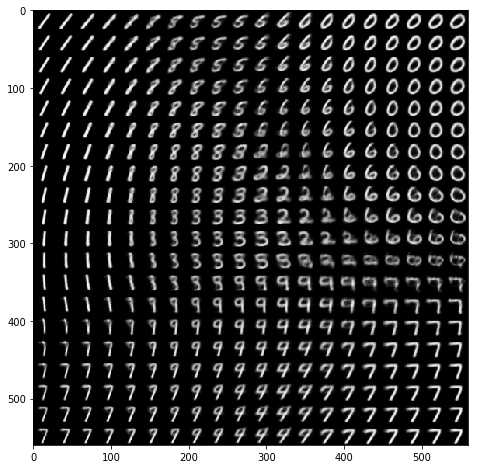

In [10]:
# Test the trained model: transformation
n = 20
x = np.linspace(-2, 2, n)
y = np.linspace(-2, 2, n)

I_latent = np.empty((h*n, w*n))
for i, yi in enumerate(x):
    for j, xi in enumerate(y):
        z = np.array([[xi, yi]]*model_2d.batch_size)
        x_hat = model_2d.generator(z)
        I_latent[(n-i-1)*28:(n-i)*28, j*28:(j+1)*28] = x_hat[0].reshape(28, 28)

plt.figure(figsize=(8, 8))        
plt.imshow(I_latent, cmap="gray")